In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from tsfresh import extract_features, select_features


In [2]:
def plot_array(array, color='blue'):
    if not color == 'blue':
        if color == 1:
            color = 'green'
        else:
            color = 'red'
    plt.figure(figsize=(15, 2))
    plt.plot(array, color=color)
    plt.show()

def append_zero_to_each_row(arr):
    zeros = np.zeros((arr.shape[0], 1))
    return np.hstack((arr, zeros))

In [3]:
df_train = pd.read_csv('data/ptbdb_train.csv')
df_test = pd.read_csv('data/ptbdb_test.csv')
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values
print(X_train.shape)
X_train = append_zero_to_each_row(X_train)
X_test = append_zero_to_each_row(X_test)
print(X_train.shape)


(11640, 187)
(11640, 188)


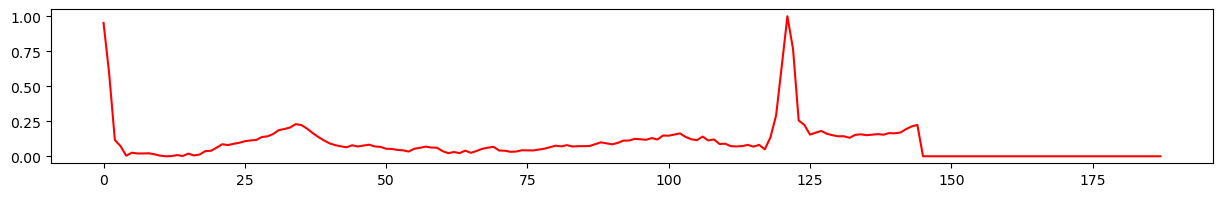

In [4]:
idx = 2
plot_array(X_train[idx], y_train[idx])

In [5]:
cls_0 = np.count_nonzero(y_train == 0)
cls_1 = np.count_nonzero(y_train == 1)
print(f'Class zero samples: {cls_0}, Class one samples: {cls_1}')
print('Based on this information, we can see that the dataset is imbalanced. We use balanced accuracy as metric.')

Class zero samples: 3237, Class one samples: 8403
Based on this information, we can see that the dataset is imbalanced. We use balanced accuracy as metric.


In [6]:
svm_clf_no_features = svm.SVC()
svm_clf_no_features.fit(X_train, y_train)

svm_preds = svm_clf_no_features.predict(X_test)
svm_acc_no_features = balanced_accuracy_score(y_test, svm_preds)
print(f'SVM balanced accuracy: {svm_acc_no_features}')

rf_clf_no_features = RandomForestClassifier()
rf_clf_no_features.fit(X_train, y_train)

rf_preds = rf_clf_no_features.predict(X_test)
rf_acc_no_features = balanced_accuracy_score(y_test, rf_preds)
print(f'Random Forest balanced accuracy: {rf_acc_no_features}')

SVM balanced accuracy: 0.8813936043937409
Random Forest balanced accuracy: 0.9519740746672194


In [7]:
df_train['id'] = range(len(df_train))
X_train.shape

(11640, 188)

In [8]:
#extracted_feautures = extract_features(df_train, column_id='id')

RNNs

In [9]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


In [10]:
def train_model(model, dataloader, epochs):
    # Define the loss function and the optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the model to the device
    model = model.to(device)
    model.train()
    # Loop over the epochs
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{epochs} Loss: {loss.item()}')
        
def create_dataloader(X, y, batch_size=32):
    # Convert X and y to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Wrap them in a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size)

    return dataloader

def get_predictions(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients
        for inputs, _ in dataloader:
            outputs = model(inputs)
            predictions.extend(outputs.detach().numpy())
    for i in range(len(predictions)):
        if predictions[i] > 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0

    return np.array(predictions)

In [11]:
class RNNModel_uni(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel_uni, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc1(out)
        return out

In [12]:
rnn_uni = RNNModel_uni(input_size=188, hidden_size=20, output_size=1)

train_loader = create_dataloader(X_train, y_train)
test_loader = create_dataloader(X_test, y_test)

In [13]:
train_model(rnn_uni, train_loader, epochs=10)

Epoch 1/10 Loss: 0.562950611114502
Epoch 2/10 Loss: 0.5527372360229492
Epoch 3/10 Loss: 0.5271729230880737
Epoch 4/10 Loss: 0.5013760328292847
Epoch 5/10 Loss: 0.47758159041404724
Epoch 6/10 Loss: 0.45576012134552
Epoch 7/10 Loss: 0.43663549423217773
Epoch 8/10 Loss: 0.42029136419296265
Epoch 9/10 Loss: 0.4061427116394043
Epoch 10/10 Loss: 0.39348745346069336


In [14]:
preds_rnn = get_predictions(rnn_uni.to('cpu'), test_loader)
rnn_uni_acc = balanced_accuracy_score(y_test, preds_rnn)
print(f'RNN unidirectional balanced accuracy: {rnn_uni_acc}')

RNN unidirectional balanced accuracy: 0.8343527145293026


In [15]:
class RNNModel_bi(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel_bi, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, output_size)


    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc1(out)
        return out

In [16]:
rnn_bi = RNNModel_bi(input_size=188, hidden_size=20, output_size=1)

In [17]:
train_model(rnn_bi, train_loader, epochs=10)

Epoch 1/10 Loss: 0.5810989737510681
Epoch 2/10 Loss: 0.5747668147087097
Epoch 3/10 Loss: 0.5498577952384949
Epoch 4/10 Loss: 0.5226210355758667
Epoch 5/10 Loss: 0.49521392583847046
Epoch 6/10 Loss: 0.468561589717865
Epoch 7/10 Loss: 0.44439369440078735
Epoch 8/10 Loss: 0.42383307218551636
Epoch 9/10 Loss: 0.4065588414669037
Epoch 10/10 Loss: 0.3916075825691223


In [18]:
preds_rnn_bi = get_predictions(rnn_bi.to('cpu'), test_loader)
rnn_bi_acc = balanced_accuracy_score(y_test, preds_rnn_bi)
print(f'RNN bidirectional balanced accuracy: {rnn_bi_acc}')

RNN bidirectional balanced accuracy: 0.8385430895610969


CNNs

In [36]:
class CNN_vanilla(nn.Module):
    def __init__(self):
        super(CNN_vanilla, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64*21, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu3(self.conv3(x))      
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
conv_vanilla = CNN_vanilla()

In [38]:
train_model(conv_vanilla, train_loader, epochs=10)

Epoch 1/10 Loss: 0.477226585149765
Epoch 2/10 Loss: 0.3644581437110901
Epoch 3/10 Loss: 0.3170540928840637
Epoch 4/10 Loss: 0.2698150873184204
Epoch 5/10 Loss: 0.19000652432441711
Epoch 6/10 Loss: 0.13961845636367798
Epoch 7/10 Loss: 0.11545458436012268
Epoch 8/10 Loss: 0.08325661718845367
Epoch 9/10 Loss: 0.0797644853591919
Epoch 10/10 Loss: 0.06020338460803032


In [39]:
preds_cnn_van = get_predictions(conv_vanilla.to('cpu'), test_loader)
cnn_van_preds = balanced_accuracy_score(y_test, preds_cnn_van)
print(f'Vanilla CNN balanced accuracy: {cnn_van_preds}')

Vanilla CNN balanced accuracy: 0.9622683724128835


In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.linear = nn.Linear(12032, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = x.unsqueeze(1)
        out = self.relu(self.bn1(self.conv1(out)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Define the model
model = ResNet(ResidualBlock, [2, 2])

In [24]:
ConvResNet = ResNet(ResidualBlock, [2, 2], num_classes=1)

In [25]:
train_model(ConvResNet, train_loader, epochs=10)

Epoch 1/10 Loss: 0.4102168083190918
Epoch 2/10 Loss: 0.16520681977272034
Epoch 3/10 Loss: 0.054639529436826706
Epoch 4/10 Loss: 0.025744736194610596
Epoch 5/10 Loss: 0.055238232016563416
Epoch 6/10 Loss: 0.0013530653668567538
Epoch 7/10 Loss: 0.0856984481215477
Epoch 8/10 Loss: 0.0010074415476992726
Epoch 9/10 Loss: 0.0008420449448749423
Epoch 10/10 Loss: 0.002857866231352091


In [26]:
preds_cnn_res = get_predictions(conv_vanilla.to('cpu'), test_loader)
cnn_res_preds = balanced_accuracy_score(y_test, preds_cnn_res)
print(f'Vanilla CNN balanced accuracy: {cnn_res_preds}')

Vanilla CNN balanced accuracy: 0.8908023711505308


Transformer based classification


In [27]:
from transformers import PatchTSTConfig, PatchTSTForClassification

config = PatchTSTConfig(
    num_input_channels=1,
    num_targets=1,
    context_length=188,
    patch_length=12,
    stride=12,
    use_cls_token=True,
)

transformer = PatchTSTForClassification(config)

In [28]:
train_model(transformer, train_loader, epochs=10)

ValueError: Input sequence length (32) doesn't match model configuration (188).